# This is the **TEMPORAL MODEL** for temp & precip from the day before

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from scipy import sparse
from sys import getsizeof
import cv2
import numpy as np
import os
import datetime as dt
import json
import sys
import matplotlib.pyplot as plt
import random
import seaborn as sns

data = {}
processed = {}
coords = {
    "limits_4326": {
        "xmin":-80.4,
        "xmax": -60.6,
        "ymin": 44.6,
        "ymax": 52.6
    }
}

target_limit =  "limits_4326" #"limits_testing_9_chunks"
xmin, xmax, ymin, ymax = (coords[target_limit]["xmin"]), (coords[target_limit]["xmax"]), (coords[target_limit]["ymin"]), (coords[target_limit]["ymax"])

chunksDirectory = "drive/MyDrive/Wildfire Research Project/Wildfires Data/Chunks"

In [ ]:
DataOrder = {
    4011: "Thunder", # 0 to 4010
    13433: "Human", # 4011 to 13432
    28433: "No-Fire", # 13433 to 28432
    43433: "No-Fire-Data" # 28433 to 43432
}

DataIntervals = {
    "Thunder": (0, 4010),
    "Human": (4011, 13432),
    "No-Fire": (13433, 28432),
    "No-Fire-Data": (28433, 43432)
}

DataTypeToOutput = {
    "Thunder": 1,
    "Human": 1,
    "No-Fire": 0,
    "No-Fire-Data": 0
}

firesCount = 11196
noFiresCount = 13350

In [ ]:
variableIndices = [
    0,
    36, # Precipitation
    72, # Temp Max
    108, # Temp Min
    229, # EVI
    350, # NDVI
    471, # Lai
    615, # Hydrography
    759, # Roads
    903 # Lines
]

parameters = [
    "Precipitation (1D Lag)",
    "Temp Max (1D Lag)",
    "Temp Min (1D Lag)",
    "EVI (16D)",
    "NDVI (16D)",
    "LAI (16D)",
    "Hydrography",
    "Roads",
    "Transmission Lines"
]

## Imports and Utils

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import math
import pickle

basePath = "drive/MyDrive/Wildfire Research Project/Models/Temporal Yesterday/"

In [ ]:
trainX = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainX_yesterday.npy")
trainY = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainY_yesterday.npy").ravel()

In [ ]:
np.count_nonzero(trainY), trainY.shape[0] - np.count_nonzero(trainY)

(1670, 1671)

In [ ]:
trainX = np.nan_to_num(trainX) # Replace nan with 0

In [ ]:
def getTrainData():
  X_train_total = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainX_yesterday.npy")
  X_train_total = np.nan_to_num(X_train_total) # Replace nan with 0
  Y_train_total = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainY_yesterday.npy").ravel()
  X_train_total, Y_train_total = shuffle(X_train_total, Y_train_total, random_state=0)

  return X_train_total, Y_train_total

In [ ]:
def mixVariable(variableIdx, testX, testY): # 1-indexed
  shuffleStart = variableIndices[variableIdx-1]
  shuffleEnd = variableIndices[variableIdx]
  testXCopy = np.copy(testX)
  print(testX.shape[0])

  for i in range(testX.shape[0]):
    randomIdx = random.randint(0, testX.shape[0]-1)
    while (randomIdx == i):
      randomIdx = random.randint(0, testX.shape[0]-1)

    for idx in range(shuffleStart, shuffleEnd):
      testXCopy[i, idx] = testX[randomIdx, idx]

  return testXCopy, testY

### Base Model

In [ ]:
rfreg_base = RandomForestClassifier(min_samples_split=10)

#### K-fold Cross Validation with Best Split

In [ ]:
X_train_total, Y_train_total = getTrainData()
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

In [ ]:
split = "50:50"


In [ ]:
def train_rf_base(split):
  accuracies_rf = []
  models_rf = []
  print("random forest")

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    rfreg_base.fit(train_x, train_y)
    accuracies_rf.append(rfreg_base.score(X_test, y_test))
    models_rf.append(rfreg_base)
    print(accuracies_rf[i])

    # Display
    print(confusion_matrix(y_test, rfreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rfreg_base.predict(X_test)), display_labels=rfreg_base.classes_).plot()
    plt.title(f"Random Forest Classifier {split[0]}-{split[1]}")
    plt.show()

  with open(basePath+split+"/random_forest_base.pkl", 'wb') as f:
    pickle.dump(models_rf, f)
  np.save(basePath+split+"/random_forest_acc", accuracies_rf)

### Confusion Matrices and Training Steps

random forest
0
0.8238805970149253
[[133  34]
 [ 25 143]]


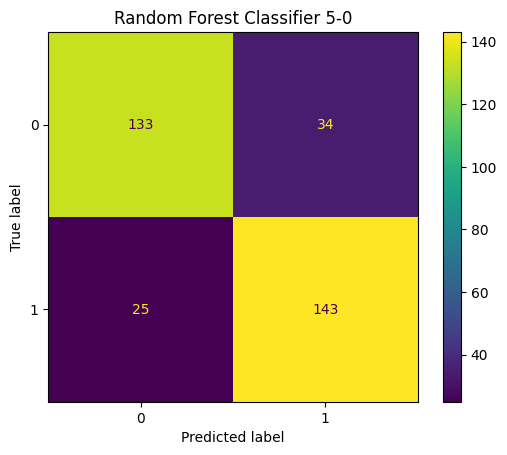

1
0.8477611940298507
[[137  30]
 [ 21 147]]


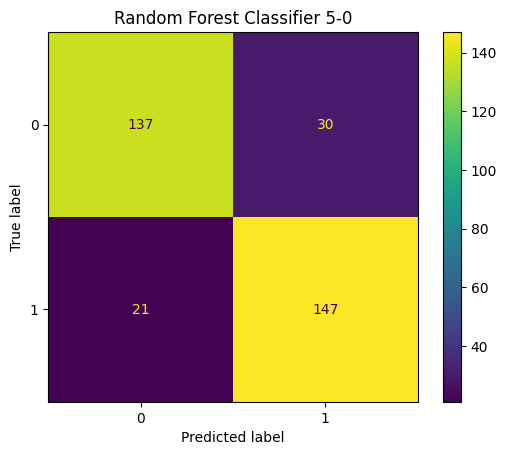

2
0.8119402985074626
[[130  37]
 [ 26 142]]


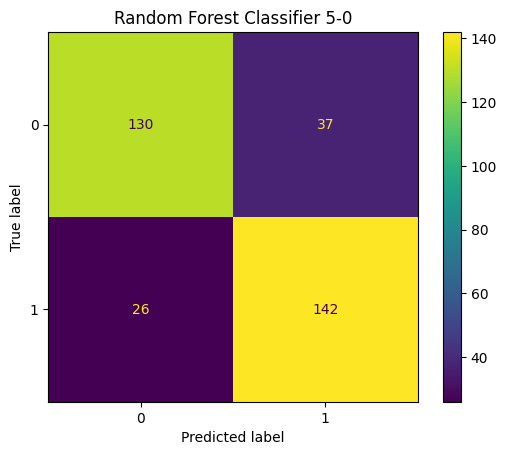

3
0.817910447761194
[[131  36]
 [ 25 143]]


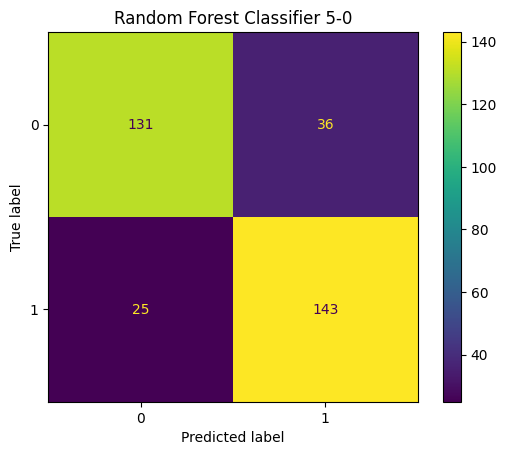

4
0.826865671641791
[[135  32]
 [ 26 142]]


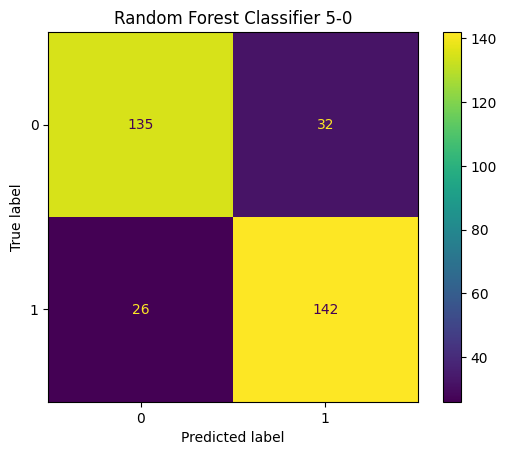

5
0.826865671641791
[[133  34]
 [ 24 144]]


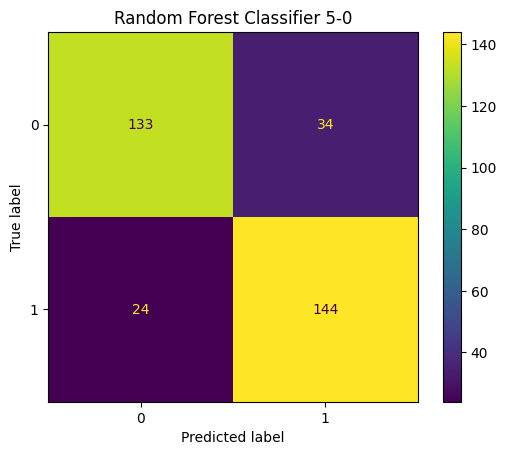

6
0.8149253731343283
[[132  35]
 [ 27 141]]


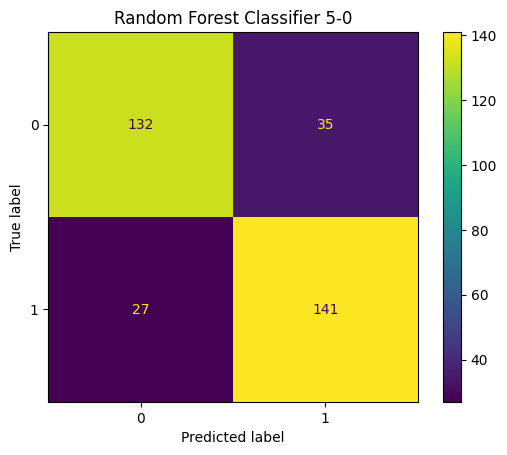

7
0.835820895522388
[[132  35]
 [ 20 148]]


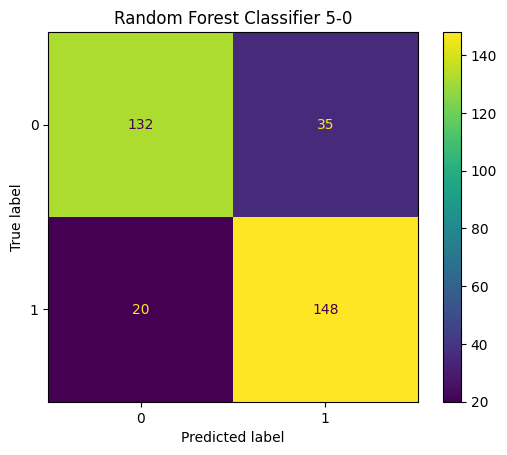

8
0.826865671641791
[[128  39]
 [ 19 149]]


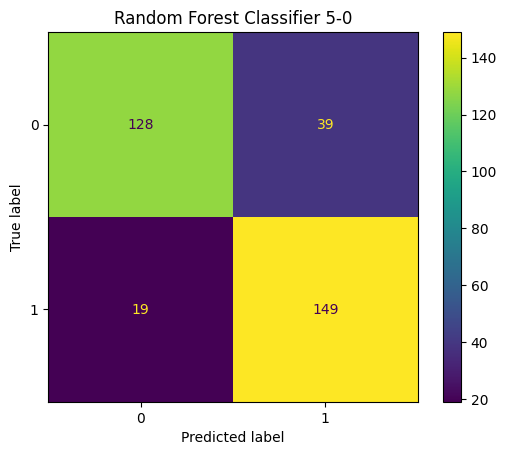

9
0.8119402985074626
[[131  36]
 [ 27 141]]


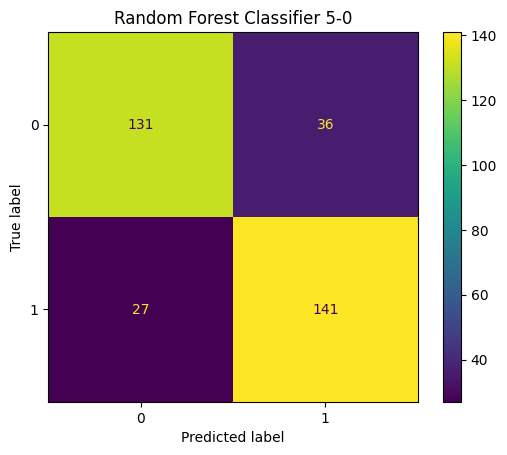

In [ ]:
train_rf_base(split)

### Analysis and Importing Models

In [ ]:
X_train_total, Y_train_total = getTrainData()
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

In [ ]:
split = "50:50"

In [ ]:
accuracies_rf = np.load(basePath+split+"/random_forest_acc.npy")

In [ ]:
np.std(accuracies_rf)

0.010663027522084634

In [ ]:
models_rf = pickle.load(open(basePath+split+"/random_forest_base.pkl", 'rb'))

In [ ]:
model_rf = models_rf[accuracies_rf.argmax(axis=0)]
acc_rf = accuracies_rf[accuracies_rf.argmax(axis=0)]
acc_rf

0.8477611940298507

In [ ]:
np.average(accuracies_rf)

0.8244776119402983

In [ ]:
axis = [0, 1]
font = {'size' : 20}

plt.rc('font', **font)

### ROC AUC Curve

In [ ]:
def plot_roc_curve(true_y, y_prob, title, color):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, color=color)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

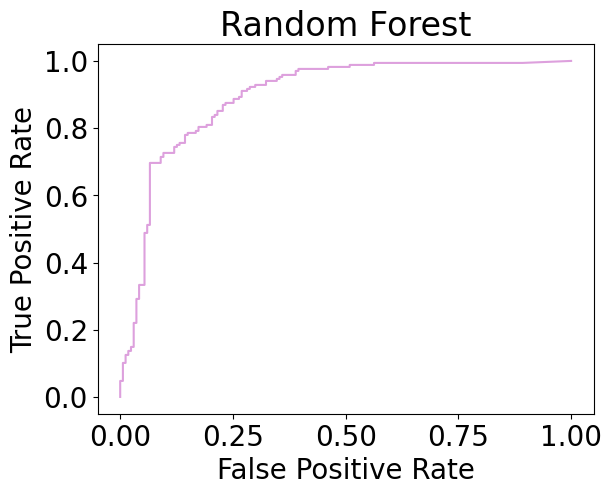

In [ ]:
plot_roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1], "Random Forest", "Plum")

[[0.82911392 0.20338983]
 [0.17088608 0.79661017]]
Random Forest Classifier - Temporal with 1 Day Lagging Data


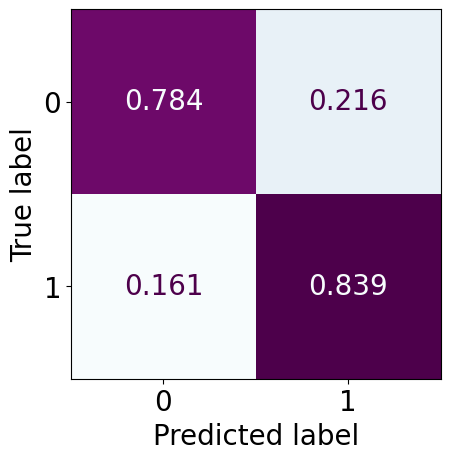

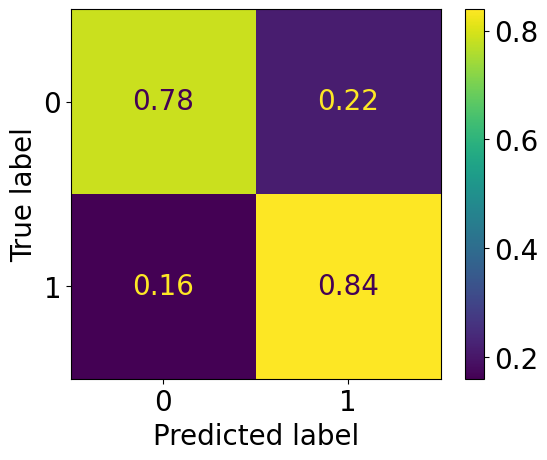

In [ ]:
print(confusion_matrix(y_test, model_rf.predict(X_test), normalize="pred"))
print("Random Forest Classifier - Temporal with 1 Day Lagging Data")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_rf.predict(X_test), normalize="true",
    display_labels=model_rf.classes_,
    colorbar=False, cmap="BuPu", values_format=".3g"
  ).plot()


# ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model_gb.predict(X_test), normalize="pred"), display_labels=model_gb.classes_).plot()
# plt.title(f"Gradient Boost Classifier - Temporal")
# plt.show()

### Mean Accuracy Decrease

In [ ]:
X_train_total, Y_train_total = getTrainData()
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

Precipitation (1D)
335
Random Forest
0.8119402985074626
0.035820895522388096
[[134  33]
 [ 30 138]]


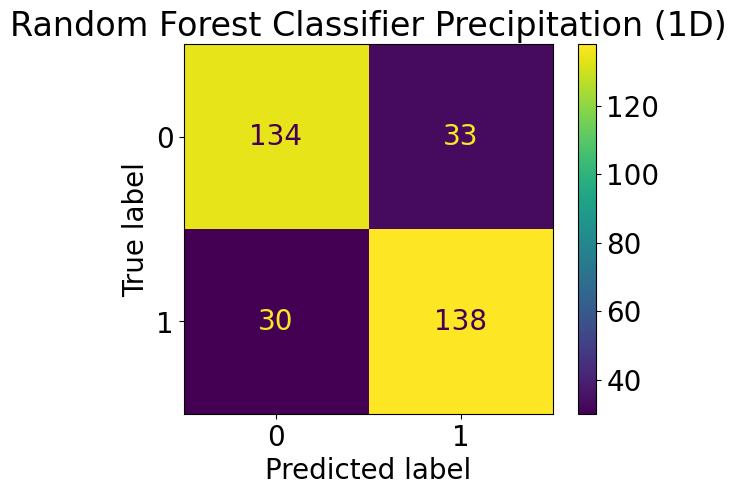

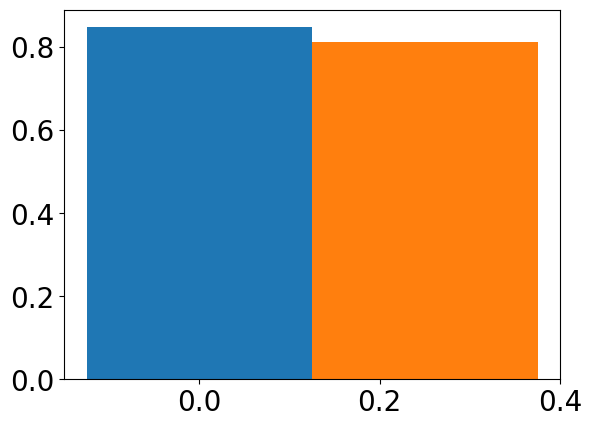

--------------------
Temp Max (1D)
335
Random Forest
0.6298507462686567
0.21791044776119406
[[114  53]
 [ 71  97]]


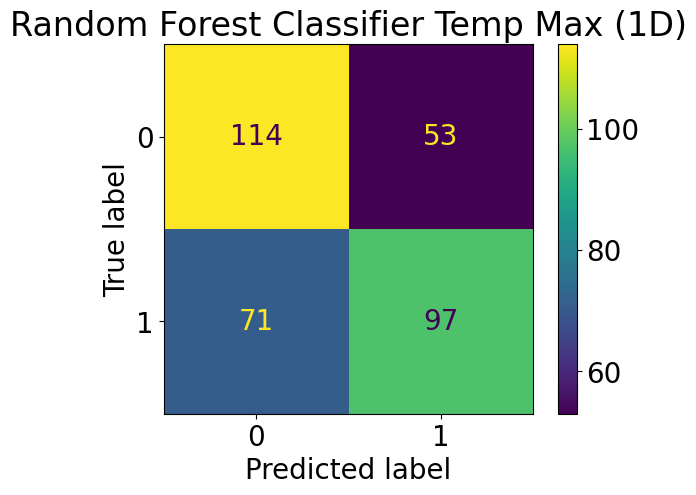

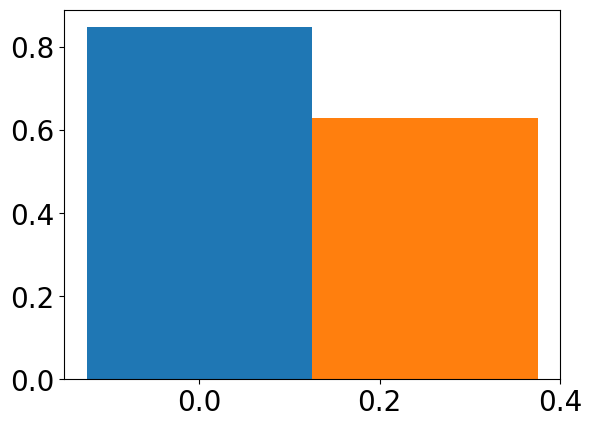

--------------------
Temp Min (1D)
335
Random Forest
0.8238805970149253
0.023880597014925398
[[135  32]
 [ 27 141]]


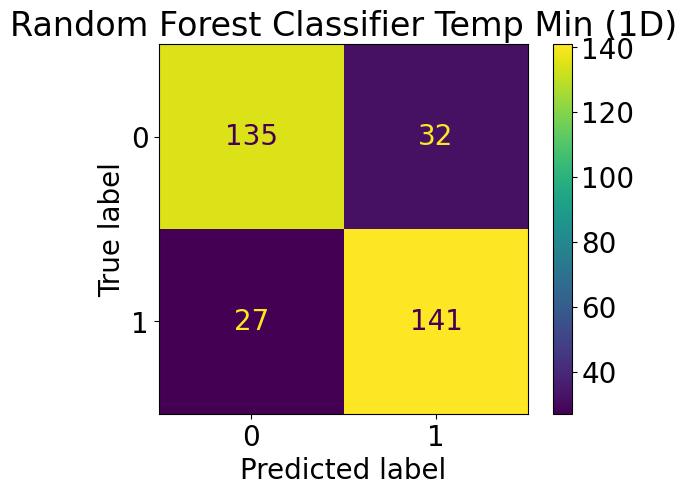

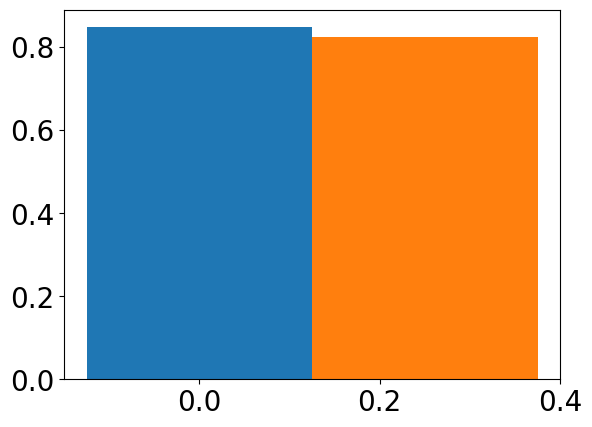

--------------------
EVI (16D)
335
Random Forest
0.7970149253731343
0.05074626865671639
[[131  36]
 [ 32 136]]


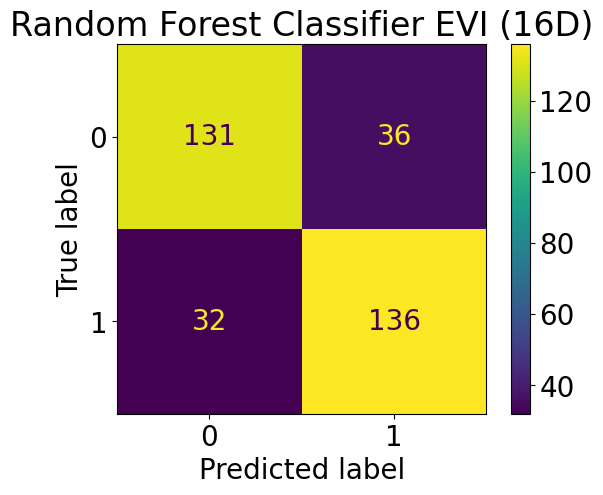

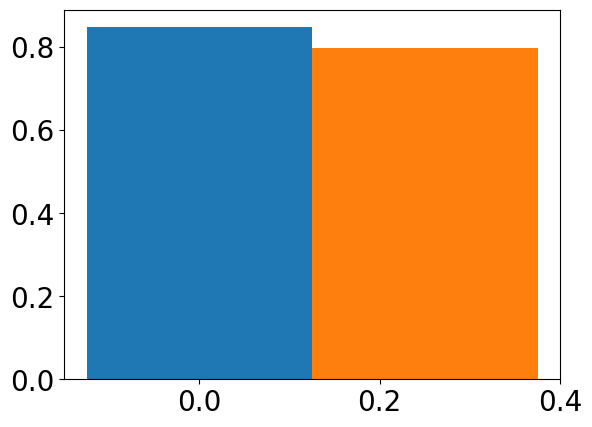

--------------------
NDVI (16D)
335
Random Forest
0.7313432835820896
0.11641791044776117
[[125  42]
 [ 48 120]]


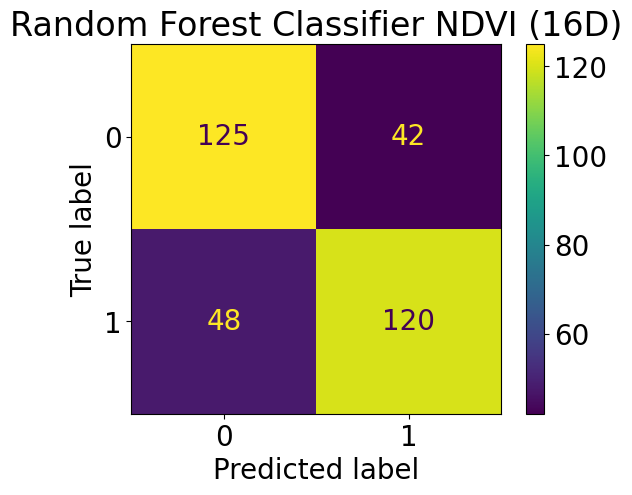

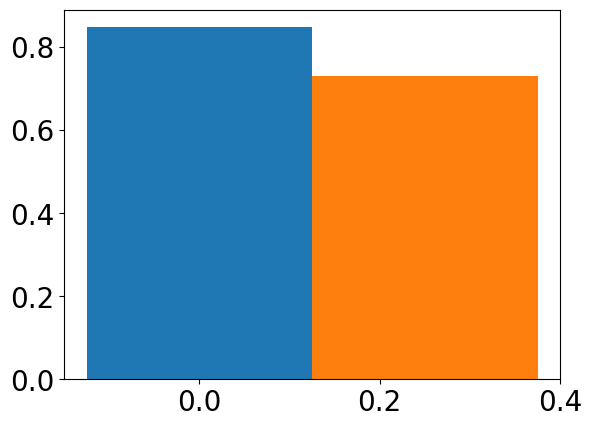

--------------------
LAI (16D)
335
Random Forest
0.808955223880597
0.03880597014925369
[[136  31]
 [ 33 135]]


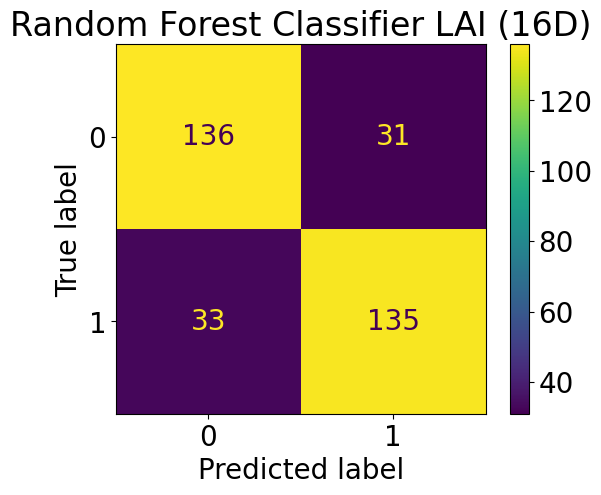

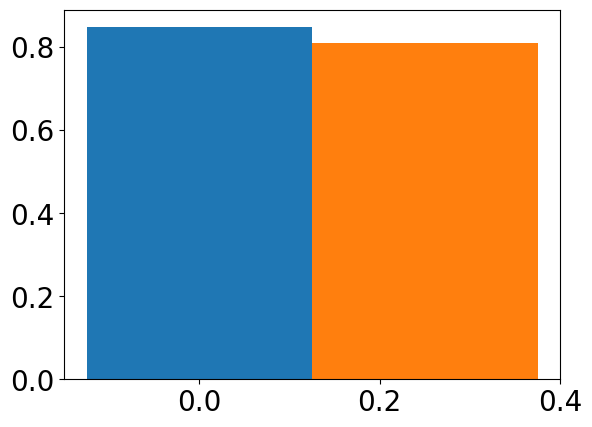

--------------------
Hydrography
335
Random Forest
0.8238805970149253
0.023880597014925398
[[133  34]
 [ 25 143]]


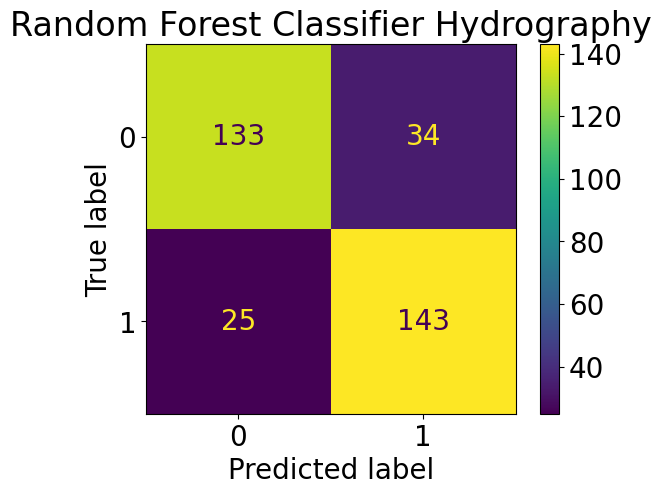

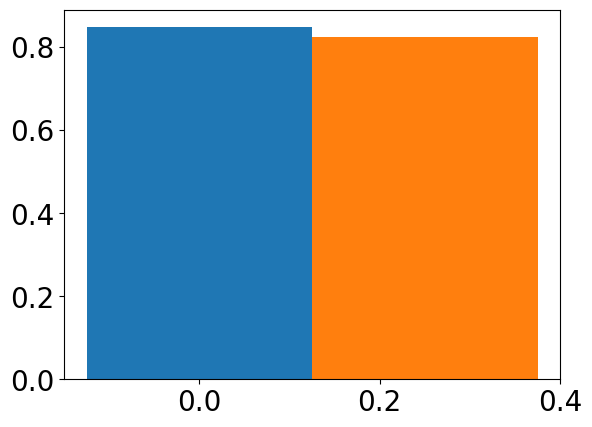

--------------------
Roads
335
Random Forest
0.8119402985074626
0.035820895522388096
[[131  36]
 [ 27 141]]


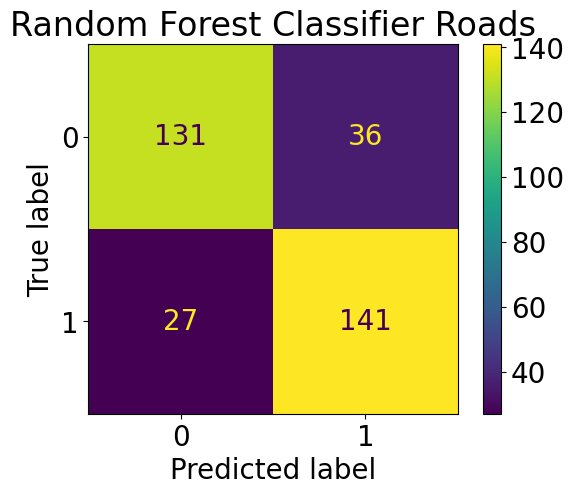

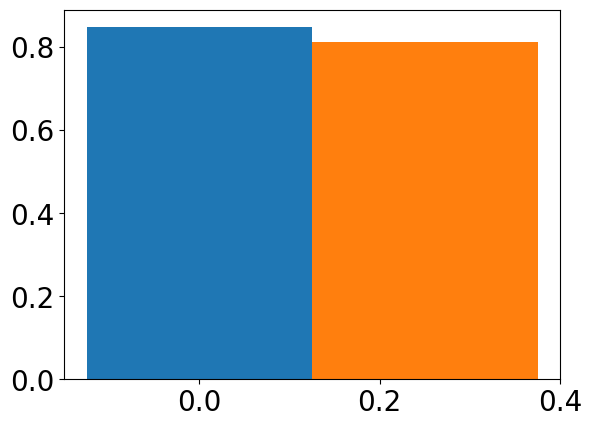

--------------------
Transmission Lines
335
Random Forest
0.8119402985074626
0.035820895522388096
[[131  36]
 [ 27 141]]


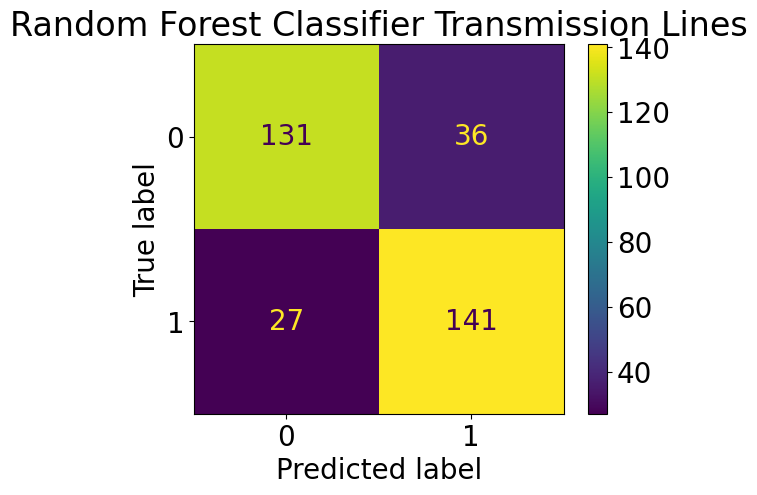

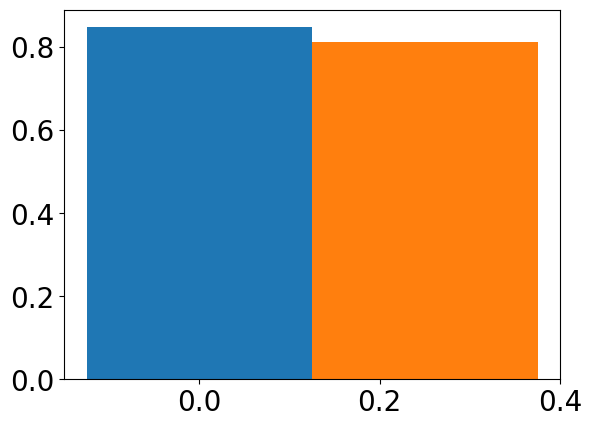

--------------------


In [ ]:
differences_rf = []

for i in range(len(variableIndices)-1):
  print(parameters[i])

  mad_test_X, mad_test_y = mixVariable(i+1, X_test , y_test)

  InitialAccuracies = [acc_rf]
  NewAccuracy = []

  print("Random Forest")
  rf_score = model_rf.score(mad_test_X, mad_test_y)
  print(rf_score)
  print(acc_rf - rf_score)
  NewAccuracy.append(rf_score)
  differences_rf.append(acc_rf - rf_score)
  # Display
  print(confusion_matrix(mad_test_y, model_rf.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_rf.predict(mad_test_X)), display_labels=model_rf.classes_).plot()
  plt.title(f"Random Forest Classifier {parameters[i]}")
  plt.show()


  barWidth = 0.25
  fig = plt.subplots()

  br1 = np.arange(len(InitialAccuracies))
  br2 = [x + barWidth for x in br1]
  plt.bar(br1, InitialAccuracies, width=barWidth, label='Initial')
  plt.bar(br2, NewAccuracy, width=barWidth, label="New")
  plt.show()

  print("-"*20)

# fig = plt.subplots()
# br1 = np.arange(len(differences_lg))
# br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]

# plt.bar(br1, differences_lg, width=barWidth, label='Logistic')
# plt.bar(br2, differences_rf, width=barWidth, label="Random Forest")
# plt.bar(br3, differences_gb, width=barWidth, label="Gradient Boost")
# plt.xticks([r + barWidth for r in range(len(differences_lg))], parameters)
# plt.legend()
# plt.show()

# barWidth = 0.25
# br1 = np.arange(len(differences_lg))
# br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]
# fig, ax = plt.subplots()

# plt.barh(br1, differences_lg, barWidth, label='Logistic', color="royalblue")
# plt.barh(br2, differences_rf, barWidth, label="Random Forest", color="blueviolet")
# plt.barh(br3, differences_gb, barWidth, label="Gradient Boost", color="orangered")
# plt.yticks([r + barWidth for r in range(len(differences_lg))], parameters)
# # plt.legend()
# plt.show()

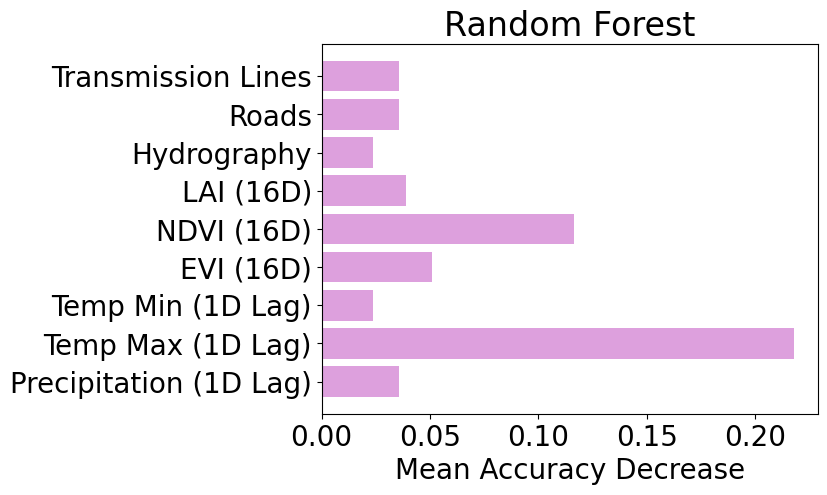

In [ ]:
fig, ax = plt.subplots()
y_pos = np.arange(len(parameters))
ax.barh(y_pos, differences_rf, align='center', color="plum")
ax.set_yticks(y_pos, labels=parameters)
ax.set_xlabel(f"Mean Accuracy Decrease")
ax.set_title(f"Random Forest")
plt.show()

# plt.bar(y_pos, differences_lg, align='center', alpha=0.5)

In [ ]:
print(differences_rf)


[0.035820895522388096, 0.21791044776119406, 0.023880597014925398, 0.05074626865671639, 0.11641791044776117, 0.03880597014925369, 0.023880597014925398, 0.035820895522388096, 0.035820895522388096]
